# 0.  Mô tả

## Seq2Seq Transformer for Vietnamese–English Machine Translation (PhoMT)

- Dataset: **PhoMT** (folder `data-mt/PhoMT/detokenization`)
- Mô hình: **Transformer Encoder–Decoder from scratch** (Attention, FFN, LayerNorm, Positional Encoding)
- Nhiệm vụ: Dịch máy **Vi → En**, huấn luyện trên PhoMT, đánh giá bằng **BLEU** và chuẩn bị file cho **Gemini Score**.

---

## Mục lục

1. [Thiết lập môi trường & cấu hình](#setup)
2. [Giới thiệu & tải dữ liệu PhoMT](#data)
3. [Tiền xử lý & Thám phá dữ liệu (EDA)](#eda)
4. [Xây dựng Vocabulary & phân tích coverage](#vocab)
5. [Dataset, DataLoader](#dataloader)
6. [Kiến trúc Transformer từ đầu](#model)
7. [Huấn luyện mô hình](#training)
8. [Đánh giá: Loss, Perplexity, BLEU](#evaluation)
9. [Xuất kết quả & Gemini Score](#gemini)


# 1. Thiết lập môi trường & cấu hình

In [1]:
# ==== Cell 1: Cài thêm thư viện (chạy 1 lần) ====
!pip install pyvi sacrebleu tqdm -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 76.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.7 MB/s eta 0:00:00


In [2]:
# ==== Cell 2: Import & cấu hình chung (Model 1B) ====
import os
import math
import random
import re
from collections import Counter
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence

from pyvi.ViTokenizer import tokenize as vi_tokenize
import sacrebleu
from tqdm.auto import tqdm

# 🔹 AMP
from torch.cuda.amp import autocast, GradScaler

# Đặt seed cho tái lập
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Thiết bị & multi-GPU
if torch.cuda.is_available():
    NUM_GPU = torch.cuda.device_count()
    device = torch.device("cuda")
    print(f"Using {NUM_GPU} GPU(s): {[torch.cuda.get_device_name(i) for i in range(NUM_GPU)]}")
else:
    NUM_GPU = 0
    device = torch.device("cpu")
    print("Using CPU")


Using 2 GPU(s): ['Tesla T4', 'Tesla T4']


In [3]:
# ==== Cell 3: Hyperparameters & đường dẫn dữ liệu PhoMT (Model 1B) ====

# --- Dữ liệu & vocab ---
MIN_LEN = 3
MAX_LEN = 64

VI_MAX_VOCAB = 20000
EN_MAX_VOCAB = 20000

MAX_TRAIN_SAMPLES = 1_500_000
MAX_VAL_SAMPLES   = None
MAX_TEST_SAMPLES  = None

BATCH_SIZE = 256
N_EPOCHS = 10
CLIP       = 1.0

# --- Model ---
D_MODEL  = 512
D_FF     = 2048
N_HEADS  = 8
N_ENC_LAYERS = 10
N_DEC_LAYERS = 6
DROPOUT  = 0.15
DROPPATH = 0.05
RES_SCALE = 0.5
REL_POS_MAX = 128

LR=5e-4; WEIGHT_DECAY=0.01; WARMUP_STEPS=6000; MIN_LR_RATIO=0.1
USE_AMP=True; USE_EMA=True; EMA_DECAY=0.999

# --- Đường dẫn PhoMT (detokenization) trên Kaggle ---
BASE_DIR = "/kaggle/input/dulieu/PhoMT"
DETOK_DIR = os.path.join(BASE_DIR, "detokenization")

TRAIN_VI = os.path.join(DETOK_DIR, "train", "train.vi")
TRAIN_EN = os.path.join(DETOK_DIR, "train", "train.en")
DEV_VI   = os.path.join(DETOK_DIR, "dev",   "dev.vi")
DEV_EN   = os.path.join(DETOK_DIR, "dev",   "dev.en")
TEST_VI  = os.path.join(DETOK_DIR, "test",  "test.vi")
TEST_EN  = os.path.join(DETOK_DIR, "test",  "test.en")

for p in [TRAIN_VI, TRAIN_EN, DEV_VI, DEV_EN, TEST_VI, TEST_EN]:
    print(p, "=>", "OK" if os.path.exists(p) else "NOT FOUND")


/kaggle/input/dulieu/PhoMT/detokenization/train/train.vi => OK
/kaggle/input/dulieu/PhoMT/detokenization/train/train.en => OK
/kaggle/input/dulieu/PhoMT/detokenization/dev/dev.vi => OK
/kaggle/input/dulieu/PhoMT/detokenization/dev/dev.en => OK
/kaggle/input/dulieu/PhoMT/detokenization/test/test.vi => OK
/kaggle/input/dulieu/PhoMT/detokenization/test/test.en => OK


# 2. Giới thiệu & tải dữ liệu PhoMT

PhoMT cung cấp dữ liệu dịch máy Việt–Anh với 3 tập:

- **train**: dùng để huấn luyện
- **dev**: dùng để làm validation (chọn mô hình, early stopping)
- **test**: dùng để đánh giá cuối cùng

Mỗi folder (`train`, `dev`, `test`) có 2 file song ngữ:

- `*.vi`: câu tiếng Việt (source)
- `*.en`: câu tiếng Anh (target)


In [4]:
# ==== Cell 4: Hàm đọc song ngữ & load PhoMT ====

def load_parallel(path_vi: str, path_en: str) -> Tuple[List[str], List[str]]:
    with open(path_vi, encoding="utf-8") as f_vi, open(path_en, encoding="utf-8") as f_en:
        vi_lines = [l.strip() for l in f_vi]
        en_lines = [l.strip() for l in f_en]

    n = min(len(vi_lines), len(en_lines))
    vi_lines, en_lines = vi_lines[:n], en_lines[:n]
    print(f"Loaded {n} sentence pairs from {os.path.basename(path_vi)} / {os.path.basename(path_en)}")
    return vi_lines, en_lines

train_vi_raw, train_en_raw = load_parallel(TRAIN_VI, TRAIN_EN)
dev_vi_raw,   dev_en_raw   = load_parallel(DEV_VI,   DEV_EN)
test_vi_raw,  test_en_raw  = load_parallel(TEST_VI,  TEST_EN)

print("\nTổng số câu:")
print("Train:", len(train_vi_raw))
print("Dev  :", len(dev_vi_raw))
print("Test :", len(test_vi_raw))


Loaded 2977999 sentence pairs from train.vi / train.en
Loaded 18719 sentence pairs from dev.vi / dev.en
Loaded 19151 sentence pairs from test.vi / test.en

Tổng số câu:
Train: 2977999
Dev  : 18719
Test : 19151


# 3. Tiền xử lý & Thám phá dữ liệu

Ở phần này:

- Cài tokenizer đơn giản cho Tiếng Việt & Tiếng Anh.
- Tokenize toàn bộ train/dev/test.
- Thống kê độ dài câu, hiển thị vài ví dụ, vẽ histogram độ dài.


In [5]:
# ==== Cell 5: Tokenizer tiếng Anh & tiếng Việt ====

def tokenize_en(text: str) -> List[str]:
    text = text.lower().strip()
    return re.findall(r"\w+|[^\w\s]", text, re.UNICODE)

def tokenize_vi(text: str) -> List[str]:
    text = text.lower().strip()
    return vi_tokenize(text).split()


In [6]:
# ==== Cell 6: Tokenize toàn bộ dữ liệu ====

train_vi_tok = [tokenize_vi(s) for s in train_vi_raw]
train_en_tok = [tokenize_en(s) for s in train_en_raw]

dev_vi_tok   = [tokenize_vi(s) for s in dev_vi_raw]
dev_en_tok   = [tokenize_en(s) for s in dev_en_raw]

test_vi_tok  = [tokenize_vi(s) for s in test_vi_raw]
test_en_tok  = [tokenize_en(s) for s in test_en_raw]

print("Ví dụ train[0]:")
print("VI  :", train_vi_raw[0])
print("VI tok:", train_vi_tok[0])
print("EN  :", train_en_raw[0])
print("EN tok:", train_en_tok[0])


Ví dụ train[0]:
VI  : Câu chuyện bắt đầu với buổi lễ đếm ngược.
VI tok: ['câu_chuyện', 'bắt_đầu', 'với', 'buổi', 'lễ', 'đếm', 'ngược', '.']
EN  : It begins with a countdown.
EN tok: ['it', 'begins', 'with', 'a', 'countdown', '.']


Độ dài trung bình:
VI train: 15.837962000658832 tokens
EN train: 16.149756262510497 tokens


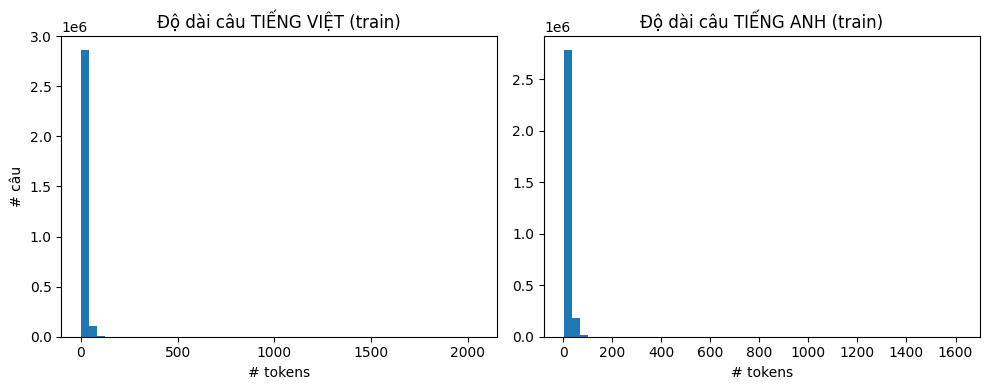

In [7]:
# ==== Cell 7: Thống kê độ dài câu & vẽ histogram (EDA) ====

def lengths(sent_tok):
    return np.array([len(s) for s in sent_tok])

train_vi_len = lengths(train_vi_tok)
train_en_len = lengths(train_en_tok)

print("Độ dài trung bình:")
print("VI train:", train_vi_len.mean(), "tokens")
print("EN train:", train_en_len.mean(), "tokens")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(train_vi_len, bins=50)
plt.title("Độ dài câu TIẾNG VIỆT (train)")
plt.xlabel("# tokens")
plt.ylabel("# câu")

plt.subplot(1,2,2)
plt.hist(train_en_len, bins=50)
plt.title("Độ dài câu TIẾNG ANH (train)")
plt.xlabel("# tokens")
plt.tight_layout()
plt.show()


In [8]:
# ==== Cell 8: Lọc câu quá ngắn / quá dài trong TRAIN (để train ổn định hơn) ====

def filter_by_length(src_tok, trg_tok, min_len=3, max_len=64):
    new_src, new_trg = [], []
    for s, t in zip(src_tok, trg_tok):
        if min_len <= len(s) <= max_len and min_len <= len(t) <= max_len:
            new_src.append(s)
            new_trg.append(t)
    return new_src, new_trg

train_vi_tok, train_en_tok = filter_by_length(
    train_vi_tok, train_en_tok,
    min_len=MIN_LEN, max_len=MAX_LEN
)

print("Sau khi lọc theo độ dài:")
print("Train VI:", len(train_vi_tok))
print("Train EN:", len(train_en_tok))


Sau khi lọc theo độ dài:
Train VI: 2953209
Train EN: 2953209


# 4. Xây dựng Vocabulary & phân tích coverage

- Xây dựng vocab cho VI/EN từ tập train.
- Giới hạn **top-K từ phổ biến** (`VI_MAX_VOCAB`, `EN_MAX_VOCAB`).
- Phần còn lại map về `<unk>`.
- Phân tích coverage: top-K từ chiếm bao nhiêu phần trăm token.


In [9]:
# ==== Cell 9: Lớp Vocab & hàm coverage ====

class Vocab:
    def __init__(self, freq_thres: int = 2, max_size: int = None):
        self.freq_thres = freq_thres
        self.max_size   = max_size

        self.PAD = "<pad>"
        self.SOS = "<sos>"
        self.EOS = "<eos>"
        self.UNK = "<unk>"

        self.itos = []
        self.stoi = {}
        self._init_special()

    def _init_special(self):
        self.itos = [self.PAD, self.SOS, self.EOS, self.UNK]
        self.stoi = {tok: i for i, tok in enumerate(self.itos)}

        self.pad_idx = self.stoi[self.PAD]
        self.sos_idx = self.stoi[self.SOS]
        self.eos_idx = self.stoi[self.EOS]
        self.unk_idx = self.stoi[self.UNK]

    def build(self, sentences: List[List[str]]):
        freq = Counter()
        for s in sentences:
            freq.update(s)

        items = [(tok, c) for tok, c in freq.items() if c >= self.freq_thres]
        items.sort(key=lambda x: x[1], reverse=True)

        if self.max_size is not None:
            items = items[:self.max_size]

        for tok, _ in items:
            if tok not in self.stoi:
                self.stoi[tok] = len(self.itos)
                self.itos.append(tok)

    def encode(self, tokens: List[str]) -> List[int]:
        return [self.stoi.get(t, self.unk_idx) for t in tokens]


def freq_list(tokenized_sents):
    c = Counter()
    for s in tokenized_sents:
        c.update(s)
    return np.array(sorted(c.values(), reverse=True), dtype=np.int64)

def coverage_at_k(freqs, k):
    k = min(k, len(freqs))
    return freqs[:k].sum() / freqs.sum() * 100.0

vi_freqs = freq_list(train_vi_tok)
en_freqs = freq_list(train_en_tok)

print("Số từ distinct VI:", len(vi_freqs))
print("Số từ distinct EN:", len(en_freqs))

cov_vi = coverage_at_k(vi_freqs, VI_MAX_VOCAB)
cov_en = coverage_at_k(en_freqs, EN_MAX_VOCAB)
print(f"Top {VI_MAX_VOCAB} từ VI cover ≈ {cov_vi:.2f}% token")
print(f"Top {EN_MAX_VOCAB} từ EN cover ≈ {cov_en:.2f}% token")


Số từ distinct VI: 320402
Số từ distinct EN: 300279
Top 20000 từ VI cover ≈ 97.63% token
Top 20000 từ EN cover ≈ 96.61% token


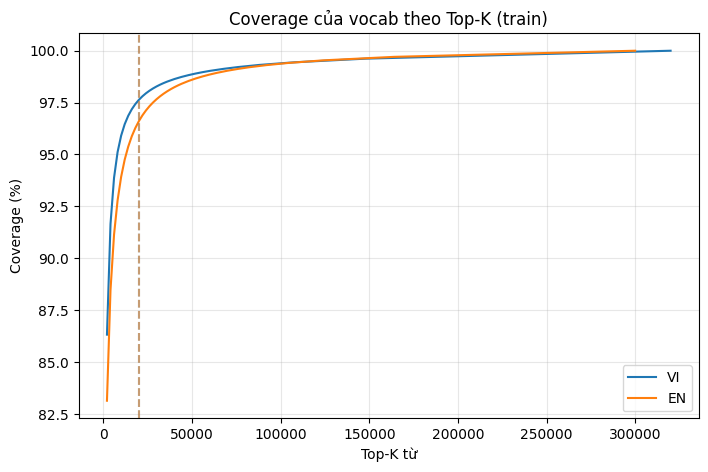

In [10]:
# ==== Cell 10: Vẽ đường cong coverage ====

def coverage_curve(freqs, step=2000):
    total = freqs.sum()
    ks, covs = [], []
    csum = freqs.cumsum()
    for k in range(step, len(freqs)+1, step):
        ks.append(k)
        covs.append(csum[k-1] / total * 100)
    return ks, covs

vi_ks, vi_covs = coverage_curve(vi_freqs)
en_ks, en_covs = coverage_curve(en_freqs)

plt.figure(figsize=(8,5))
plt.plot(vi_ks, vi_covs, label="VI")
plt.plot(en_ks, en_covs, label="EN")
plt.axvline(VI_MAX_VOCAB, color="tab:blue", linestyle="--", alpha=0.5)
plt.axvline(EN_MAX_VOCAB, color="tab:orange", linestyle="--", alpha=0.5)
plt.xlabel("Top-K từ")
plt.ylabel("Coverage (%)")
plt.title("Coverage của vocab theo Top-K (train)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [11]:
# ==== Cell 11: Build vocab ====

vi_vocab = Vocab(freq_thres=2, max_size=VI_MAX_VOCAB)
vi_vocab.build(train_vi_tok)

en_vocab = Vocab(freq_thres=2, max_size=EN_MAX_VOCAB)
en_vocab.build(train_en_tok)

print("Vocab VI:", len(vi_vocab.itos))
print("Vocab EN:", len(en_vocab.itos))


Vocab VI: 20004
Vocab EN: 20004


# 5. Dataset, DataLoader

- Dùng PhoMT:
  - `train` cho training
  - `dev` cho validation
  - `test` cho đánh giá cuối cùng
- Mỗi mẫu:
  - Thêm `<sos>` + `<eos>` ở đầu/cuối.
  - Giới hạn tối đa `MAX_LEN` token.
- Dùng `Collate` để padding theo batch.

In [12]:
# ==== Cell 12: Dataset & Collate ====

class MTDataset(Dataset):
    def __init__(self, src_sents, trg_sents, src_vocab: Vocab, trg_vocab: Vocab, max_len=64):
        self.src_sents = src_sents
        self.trg_sents = trg_sents
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab
        self.max_len   = max_len

    def __len__(self):
        return len(self.src_sents)

    def __getitem__(self, idx):
        src_tokens = self.src_sents[idx][: self.max_len - 2]
        trg_tokens = self.trg_sents[idx][: self.max_len - 2]

        src_ids = [self.src_vocab.sos_idx] + self.src_vocab.encode(src_tokens) + [self.src_vocab.eos_idx]
        trg_ids = [self.trg_vocab.sos_idx] + self.trg_vocab.encode(trg_tokens) + [self.trg_vocab.eos_idx]

        return torch.tensor(src_ids), torch.tensor(trg_ids)


class Collate:
    def __init__(self, pad_idx, max_len=64):
        self.pad_idx = pad_idx
        self.max_len = max_len

    def __call__(self, batch):
        src, trg = zip(*batch)
        src = [s[:self.max_len] for s in src]
        trg = [t[:self.max_len] for t in trg]

        src = pad_sequence(src, batch_first=True, padding_value=self.pad_idx)
        trg = pad_sequence(trg, batch_first=True, padding_value=self.pad_idx)
        return src, trg


In [13]:
# ==== Cell 13: Tạo Dataset & (tuỳ chọn) giới hạn số mẫu ====

train_ds = MTDataset(train_vi_tok, train_en_tok, vi_vocab, en_vocab, max_len=MAX_LEN)
val_ds   = MTDataset(dev_vi_tok,   dev_en_tok,   vi_vocab, en_vocab, max_len=MAX_LEN)
test_ds  = MTDataset(test_vi_tok,  test_en_tok,  vi_vocab, en_vocab, max_len=MAX_LEN)

def make_subset(ds, max_samples):
    if max_samples is None or max_samples >= len(ds):
        return ds
    idx = random.sample(range(len(ds)), max_samples)
    return Subset(ds, idx)

train_ds = make_subset(train_ds, MAX_TRAIN_SAMPLES)
val_ds   = make_subset(val_ds,   MAX_VAL_SAMPLES)
test_ds  = make_subset(test_ds,  MAX_TEST_SAMPLES)

print("Train samples:", len(train_ds))
print("Valid samples:", len(val_ds))
print("Test  samples:", len(test_ds))


Train samples: 1500000
Valid samples: 18719
Test  samples: 19151


In [14]:
# ==== Cell 14: DataLoader ====

pad_idx = vi_vocab.pad_idx

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=Collate(pad_idx, max_len=MAX_LEN)
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=Collate(pad_idx, max_len=MAX_LEN)
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=Collate(pad_idx, max_len=MAX_LEN)
)

print("Batches train:", len(train_loader))
print("Batches valid:", len(val_loader))
print("Batches test :", len(test_loader))


Batches train: 5860
Batches valid: 74
Batches test : 75


# 6. Kiến trúc Transformer from scratch

Triển khai từ các thành phần:

- Positional Encoding
- Multi-Head Attention (Scaled Dot-Product)
- Feed-Forward Network (FFN)
- Encoder Layer, Decoder Layer
- Full Transformer Seq2Seq

In [15]:
# ==== Cell 15: Positional Encoding & Embedding (UPDATED: token-only embedding) ====

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model, dropout=0.1):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, d_model)
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(d_model)

    def forward(self, x):
        # (B, T) -> (B, T, D)
        return self.dropout(self.emb(x) * self.scale)


In [ ]:
# ==== Cell 16: Multi-Head Attention, FFN, Encoder & Decoder layers ====
import torch.nn.functional as F

class DropPath(nn.Module):
    """Stochastic Depth: drop residual branch per sample."""
    def __init__(self, p: float = 0.0):
        super().__init__()
        self.p = float(p)

    def forward(self, x):
        if self.p == 0.0 or (not self.training):
            return x
        keep_prob = 1.0 - self.p
        shape = (x.size(0),) + (1,) * (x.ndim - 1)  # (B,1,1,...)
        mask = x.new_empty(shape).bernoulli_(keep_prob)
        return x * mask / keep_prob


class RelativePositionBias(nn.Module):
    """
    Simple clipped relative position bias:
      rel = clamp(i-j, -max_dist, max_dist) + max_dist
      bias_table: (2*max_dist+1, n_heads)
      return: (1, n_heads, q_len, k_len)
    """
    def __init__(self, n_heads: int, max_dist: int = 128):
        super().__init__()
        self.n_heads = n_heads
        self.max_dist = max_dist
        self.bias = nn.Embedding(2 * max_dist + 1, n_heads)

    def forward(self, q_len: int, k_len: int, device=None, dtype=None):
        q_pos = torch.arange(q_len, device=device)[:, None]
        k_pos = torch.arange(k_len, device=device)[None, :]
        rel = (q_pos - k_pos).clamp(-self.max_dist, self.max_dist) + self.max_dist  # (q,k)

        b = self.bias(rel)                # (q,k,h)
        b = b.permute(2, 0, 1).unsqueeze(0)  # (1,h,q,k)
        if dtype is not None:
            b = b.to(dtype=dtype)
        return b


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1,
                 use_rel_pos_bias: bool = False, rel_pos_max: int = 128):
        super().__init__()
        assert d_model % n_heads == 0
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.head_dim)

        self.rel_pos = RelativePositionBias(n_heads, rel_pos_max) if use_rel_pos_bias else None

    def forward(self, q, k, v, mask=None):
        B, Q_len, _ = q.size()
        K_len = k.size(1)

        def split(x):
            return x.view(B, -1, self.n_heads, self.head_dim).transpose(1, 2)  # (B,h,T,hd)

        Q = split(self.w_q(q))
        K = split(self.w_k(k))
        V = split(self.w_v(v))

        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale  # (B,h,Q,K)

        # + relative position bias (only if enabled)
        if self.rel_pos is not None:
            scores = scores + self.rel_pos(Q_len, K_len, device=scores.device, dtype=scores.dtype)

        if mask is not None:
            mask = mask.to(torch.bool)  # expected broadcastable to (B,1,Q,K) or (B,1,1,K)
            scores = scores.masked_fill(~mask, torch.finfo(scores.dtype).min)

        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        out = torch.matmul(attn, V)  # (B,h,Q,hd)
        out = out.transpose(1, 2).contiguous().view(B, Q_len, self.d_model)
        out = self.w_o(out)
        return out


class GEGLUFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        # project to 2*d_ff then chunk -> (u, v)
        self.fc1 = nn.Linear(d_model, 2 * d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        u, v = self.fc1(x).chunk(2, dim=-1)
        x = F.gelu(u) * v
        x = self.dropout(x)
        x = self.fc2(x)
        return x


class EncoderLayer(nn.Module):
    """Pre-LN EncoderLayer: x = x + sublayer(LN(x))"""
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1,
                 droppath=0.0, res_scale=1.0, rel_pos_max=128):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout,
                                            use_rel_pos_bias=True, rel_pos_max=rel_pos_max)
        self.ffn = GEGLUFeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)

        self.dp1 = DropPath(droppath)
        self.dp2 = DropPath(droppath)

        self.res_scale = res_scale

    def forward(self, x, mask):
        h = self.norm1(x)
        x = x + self.dp1(self.drop1(self.self_attn(h, h, h, mask)) * self.res_scale)

        h = self.norm2(x)
        x = x + self.dp2(self.drop2(self.ffn(h)) * self.res_scale)
        return x


class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff,
                 dropout, droppath, res_scale, rel_pos_max):
        super().__init__()
        self.emb = TokenEmbedding(vocab_size, d_model, dropout)

        # droppath schedule: tăng dần theo depth
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, d_ff, dropout,
                         droppath=droppath * (i / max(1, n_layers - 1)),
                         res_scale=res_scale,
                         rel_pos_max=rel_pos_max)
            for i in range(n_layers)
        ])
        self.final_norm = nn.LayerNorm(d_model)

    def forward(self, src, src_mask):
        x = self.emb(src)
        for layer in self.layers:
            x = layer(x, src_mask)
        return self.final_norm(x)


class DecoderLayer(nn.Module):
    """Pre-LN DecoderLayer"""
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1,
                 droppath=0.0, res_scale=1.0, rel_pos_max=128):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout,
                                            use_rel_pos_bias=True, rel_pos_max=rel_pos_max)
        self.cross_attn = MultiHeadAttention(d_model, n_heads, dropout,
                                             use_rel_pos_bias=False)

        self.ffn = GEGLUFeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)
        self.drop3 = nn.Dropout(dropout)

        self.dp1 = DropPath(droppath)
        self.dp2 = DropPath(droppath)
        self.dp3 = DropPath(droppath)

        self.res_scale = res_scale

    def forward(self, x, enc_out, trg_mask, src_mask):
        h = self.norm1(x)
        x = x + self.dp1(self.drop1(self.self_attn(h, h, h, trg_mask)) * self.res_scale)

        h = self.norm2(x)
        x = x + self.dp2(self.drop2(self.cross_attn(h, enc_out, enc_out, src_mask)) * self.res_scale)

        h = self.norm3(x)
        x = x + self.dp3(self.drop3(self.ffn(h)) * self.res_scale)
        return x


class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff,
                 dropout, droppath, res_scale, rel_pos_max):
        super().__init__()
        self.emb = TokenEmbedding(vocab_size, d_model, dropout)

        self.layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, d_ff, dropout,
                         droppath=droppath * (i / max(1, n_layers - 1)),
                         res_scale=res_scale,
                         rel_pos_max=rel_pos_max)
            for i in range(n_layers)
        ])
        self.final_norm = nn.LayerNorm(d_model)

        # output projection (tie with embedding)
        self.fc_out = nn.Linear(d_model, vocab_size, bias=False)
        self.fc_out.weight = self.emb.emb.weight  # weight tying

    def forward(self, trg, enc_out, trg_mask, src_mask):
        x = self.emb(trg)
        for layer in self.layers:
            x = layer(x, enc_out, trg_mask, src_mask)
        x = self.final_norm(x)
        return self.fc_out(x)


In [ ]:
# ==== Cell 17: Mask & model wrapper (UPDATED) ====

def make_src_mask(src, pad_idx):
    # (B,S) -> (B,1,1,S)
    return (src != pad_idx).unsqueeze(1).unsqueeze(2)

def make_trg_mask(trg, pad_idx):
    # (B,T) -> pad mask (B,1,1,T)
    pad_mask = (trg != pad_idx).unsqueeze(1).unsqueeze(2)
    T = trg.size(1)
    # causal mask (1,1,T,T)
    sub_mask = torch.tril(torch.ones(T, T, device=trg.device, dtype=torch.bool)).unsqueeze(0).unsqueeze(1)
    return pad_mask & sub_mask


class Transformer(nn.Module):
    def __init__(self,
                 src_vocab_size, trg_vocab_size,
                 src_pad_idx, trg_pad_idx,
                 d_model, n_heads, d_ff,
                 n_enc_layers, n_dec_layers,
                 dropout=0.1,
                 droppath=0.0,
                 res_scale=1.0,
                 rel_pos_max=128):
        super().__init__()
        self.encoder = Encoder(src_vocab_size, d_model, n_enc_layers, n_heads, d_ff,
                               dropout=dropout, droppath=droppath, res_scale=res_scale, rel_pos_max=rel_pos_max)
        self.decoder = Decoder(trg_vocab_size, d_model, n_dec_layers, n_heads, d_ff,
                               dropout=dropout, droppath=droppath, res_scale=res_scale, rel_pos_max=rel_pos_max)

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx

        # (optional) init weights
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src, trg):
        src_mask = make_src_mask(src, self.src_pad_idx)
        trg_mask = make_trg_mask(trg, self.trg_pad_idx)
        enc_out  = self.encoder(src, src_mask)
        out      = self.decoder(trg, enc_out, trg_mask, src_mask)
        return out


# 7. Huấn luyện mô hình

- Loss: Cross-Entropy với **Label Smoothing**.
- Optimizer: Adam.
- Scheduler: **Noam (warmup)** giống paper Transformer.
- Hỗ trợ **multi-GPU** với `nn.DataParallel`.
- Có **thanh tiến trình tqdm**.

In [18]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing, vocab_size, ignore_index):
        super().__init__()
        self.smoothing = smoothing
        self.vocab_size = vocab_size
        self.ignore_index = ignore_index

    def forward(self, logits, target):
        # logits: (N, V), target: (N,)
        log_probs = F.log_softmax(logits, dim=-1)  # (N,V)

        # NLL loss (hard target)
        nll = F.nll_loss(log_probs, target, reduction='none', ignore_index=self.ignore_index)

        # smooth loss = mean(-log_probs) over vocab
        smooth = -log_probs.mean(dim=-1)

        # mask pad
        mask = (target != self.ignore_index).float()
        nll = (nll * mask).sum() / mask.sum().clamp_min(1.0)
        smooth = (smooth * mask).sum() / mask.sum().clamp_min(1.0)

        return (1.0 - self.smoothing) * nll + self.smoothing * smooth

In [ ]:
# ==== Cell 18: Khởi tạo model, optimizer, criterion, scheduler  ====

from torch.optim.lr_scheduler import LambdaLR
from torch.cuda.amp import GradScaler

SRC_VOCAB = len(vi_vocab.itos)
TRG_VOCAB = len(en_vocab.itos)
SRC_PAD   = vi_vocab.pad_idx
TRG_PAD   = en_vocab.pad_idx

model = Transformer(
    src_vocab_size=SRC_VOCAB,
    trg_vocab_size=TRG_VOCAB,
    src_pad_idx=SRC_PAD,
    trg_pad_idx=TRG_PAD,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    d_ff=D_FF,
    n_enc_layers=N_ENC_LAYERS,
    n_dec_layers=N_DEC_LAYERS,
    dropout=DROPOUT,
    droppath=DROPPATH,
    res_scale=RES_SCALE,
    rel_pos_max=REL_POS_MAX
).to(device)

if NUM_GPU > 1:
    model = nn.DataParallel(model)
    print("Using DataParallel")

def unwrap_model(m):
    return m.module if isinstance(m, nn.DataParallel) else m

# --- Optimizer: AdamW ---
optimizer = optim.AdamW(
    model.parameters(),
    lr=LR,
    betas=(0.9, 0.98),
    eps=1e-9,
    weight_decay=WEIGHT_DECAY
)

# --- Scheduler: warmup + cosine decay to MIN_LR_RATIO * LR ---
total_steps = N_EPOCHS * len(train_loader)

def lr_lambda(step):
    step = max(1, step)
    if step <= WARMUP_STEPS:
        return step / float(WARMUP_STEPS)
    progress = (step - WARMUP_STEPS) / float(max(1, total_steps - WARMUP_STEPS))
    cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
    return MIN_LR_RATIO + (1.0 - MIN_LR_RATIO) * cosine

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

# --- Label smoothing loss ---
criterion = LabelSmoothingLoss(0.1, TRG_VOCAB, ignore_index=TRG_PAD).to(device)

# --- AMP scaler ---
scaler = GradScaler(enabled=(USE_AMP and device.type == "cuda"))

# --- EMA ---
class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        for name, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[name] = p.detach().clone()

    @torch.no_grad()
    def update(self, model):
        for name, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[name].mul_(self.decay).add_(p.detach(), alpha=1.0 - self.decay)

    @torch.no_grad()
    def apply_to(self, model):
        self.backup = {}
        for name, p in model.named_parameters():
            if p.requires_grad:
                self.backup[name] = p.detach().clone()
                p.data.copy_(self.shadow[name])

    @torch.no_grad()
    def restore(self, model):
        for name, p in model.named_parameters():
            if p.requires_grad:
                p.data.copy_(self.backup[name])
        self.backup = {}

ema = EMA(unwrap_model(model), decay=EMA_DECAY) if USE_EMA else None


Using DataParallel


/tmp/ipykernel_47/294510744.py:60: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(USE_AMP and device.type == "cuda"))


In [20]:
# ==== Cell 19: train_one_epoch & evaluate (UPDATED: AMP + EMA) ====

from torch.cuda.amp import autocast

def train_one_epoch(model, loader, optimizer, scheduler, criterion,
                    epoch, total_epochs, clip=1.0, max_batches=None,
                    scaler=None, ema=None):
    model.train()
    total_loss = 0
    total_tokens = 0

    bar = tqdm(loader, desc=f"Train {epoch}/{total_epochs}", leave=False)
    for i, (src, trg) in enumerate(bar):
        if max_batches is not None and i >= max_batches:
            break

        src, trg = src.to(device), trg.to(device)
        trg_in  = trg[:, :-1]
        trg_out = trg[:, 1:]

        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=(scaler is not None and scaler.is_enabled())):
            logits = model(src, trg_in)            # (B, T-1, V)
            B, T, V = logits.shape
            logits_flat = logits.reshape(-1, V)
            trg_out_flat = trg_out.reshape(-1)
            loss = criterion(logits_flat.float(), trg_out_flat)  # loss float32

        # backward
        if scaler is not None and scaler.is_enabled():
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

        scheduler.step()

        # EMA update
        if ema is not None:
            base = model.module if isinstance(model, nn.DataParallel) else model
            ema.update(base)

        non_pad = trg_out_flat != TRG_PAD
        n_tok = non_pad.sum().item()

        total_loss   += loss.item() * n_tok
        total_tokens += n_tok

        cur_loss = total_loss / max(total_tokens, 1)
        bar.set_postfix(loss=f"{cur_loss:.4f}")

    mean_loss = total_loss / total_tokens
    ppl = math.exp(mean_loss)
    return mean_loss, ppl


@torch.no_grad()
def evaluate(model, loader, criterion, epoch, total_epochs, max_batches=None,
             scaler=None):
    model.eval()
    total_loss = 0
    total_tokens = 0

    bar = tqdm(loader, desc=f"Valid {epoch}/{total_epochs}", leave=False)
    for i, (src, trg) in enumerate(bar):
        if max_batches is not None and i >= max_batches:
            break

        src, trg = src.to(device), trg.to(device)
        trg_in  = trg[:, :-1]
        trg_out = trg[:, 1:]

        with autocast(enabled=(scaler is not None and scaler.is_enabled())):
            logits = model(src, trg_in)
            B, T, V = logits.shape
            logits_flat = logits.reshape(-1, V)
            trg_out_flat = trg_out.reshape(-1)
            loss = criterion(logits_flat.float(), trg_out_flat)

        non_pad = trg_out_flat != TRG_PAD
        n_tok = non_pad.sum().item()

        total_loss   += loss.item() * n_tok
        total_tokens += n_tok

        cur_loss = total_loss / max(total_tokens, 1)
        bar.set_postfix(loss=f"{cur_loss:.4f}")

    mean_loss = total_loss / total_tokens
    ppl = math.exp(mean_loss)
    return mean_loss, ppl


In [21]:
# ==== Cell 20: Vòng lặp huấn luyện chính (UPDATED: EMA apply on val) ====

history = {"train_loss": [], "train_ppl": [],
           "val_loss":   [], "val_ppl":   [],
           "lr": []}

best_val = float("inf")
SAVE_PATH = "transformer_vi_en_phomt.pth"

for epoch in range(1, N_EPOCHS + 1):
    train_loss, train_ppl = train_one_epoch(
        model, train_loader, optimizer, scheduler, criterion,
        epoch, N_EPOCHS,
        clip=CLIP,
        scaler=scaler,
        ema=ema
    )

    # validate with EMA weights (if enabled)
    if ema is not None:
        base = model.module if isinstance(model, nn.DataParallel) else model
        ema.apply_to(base)

    val_loss, val_ppl = evaluate(
        model, val_loader, criterion,
        epoch, N_EPOCHS,
        scaler=scaler
    )

    if ema is not None:
        base = model.module if isinstance(model, nn.DataParallel) else model
        ema.restore(base)

    cur_lr = optimizer.param_groups[0]["lr"]

    history["train_loss"].append(train_loss)
    history["train_ppl"].append(train_ppl)
    history["val_loss"].append(val_loss)
    history["val_ppl"].append(val_ppl)
    history["lr"].append(cur_lr)

    if val_loss < best_val:
        best_val = val_loss

        # save EMA weights (if enabled) because val used EMA
        to_save = model.module if isinstance(model, nn.DataParallel) else model
        if ema is not None:
            ema.apply_to(to_save)
            torch.save(to_save.state_dict(), SAVE_PATH)
            ema.restore(to_save)
        else:
            torch.save(to_save.state_dict(), SAVE_PATH)

    print(f"[Epoch {epoch}/{N_EPOCHS}] "
          f"Train Loss {train_loss:.4f} | PPL {train_ppl:.2f} || "
          f"Val Loss {val_loss:.4f} | PPL {val_ppl:.2f} || "
          f"LR {cur_lr:.6f}")

print("Best validation loss:", best_val)
print("Saved best checkpoint to:", SAVE_PATH)


Train 1/10:   0%|          | 0/5860 [00:00<?, ?it/s]

/tmp/ipykernel_47/2050644599.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None and scaler.is_enabled())):


Valid 1/10:   0%|          | 0/74 [00:00<?, ?it/s]

/tmp/ipykernel_47/2050644599.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None and scaler.is_enabled())):


[Epoch 1/10] Train Loss 4.7519 | PPL 115.81 || Val Loss 3.3053 | PPL 27.26 || LR 0.000488


Train 2/10:   0%|          | 0/5860 [00:00<?, ?it/s]

Valid 2/10:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 2/10] Train Loss 3.1257 | PPL 22.78 || Val Loss 2.8195 | PPL 16.77 || LR 0.000487


Train 3/10:   0%|          | 0/5860 [00:00<?, ?it/s]

Valid 3/10:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 3/10] Train Loss 2.9014 | PPL 18.20 || Val Loss 2.7120 | PPL 15.06 || LR 0.000448


Train 4/10:   0%|          | 0/5860 [00:00<?, ?it/s]

Valid 4/10:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 4/10] Train Loss 2.7960 | PPL 16.38 || Val Loss 2.6575 | PPL 14.26 || LR 0.000389


Train 5/10:   0%|          | 0/5860 [00:00<?, ?it/s]

Valid 5/10:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 5/10] Train Loss 2.7206 | PPL 15.19 || Val Loss 2.6243 | PPL 13.80 || LR 0.000315


Train 6/10:   0%|          | 0/5860 [00:00<?, ?it/s]

Valid 6/10:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 6/10] Train Loss 2.6590 | PPL 14.28 || Val Loss 2.6023 | PPL 13.49 || LR 0.000237


Train 7/10:   0%|          | 0/5860 [00:00<?, ?it/s]

Valid 7/10:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 7/10] Train Loss 2.6052 | PPL 13.53 || Val Loss 2.5886 | PPL 13.31 || LR 0.000163


Train 8/10:   0%|          | 0/5860 [00:00<?, ?it/s]

Valid 8/10:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 8/10] Train Loss 2.5597 | PPL 12.93 || Val Loss 2.5802 | PPL 13.20 || LR 0.000103


Train 9/10:   0%|          | 0/5860 [00:00<?, ?it/s]

Valid 9/10:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 9/10] Train Loss 2.5242 | PPL 12.48 || Val Loss 2.5771 | PPL 13.16 || LR 0.000064


Train 10/10:   0%|          | 0/5860 [00:00<?, ?it/s]

Valid 10/10:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 10/10] Train Loss 2.5016 | PPL 12.20 || Val Loss 2.5759 | PPL 13.14 || LR 0.000050
Best validation loss: 2.5758616303682906
Saved best checkpoint to: transformer_vi_en_phomt.pth


# 8. Đánh giá: Loss, PPL, BLEU

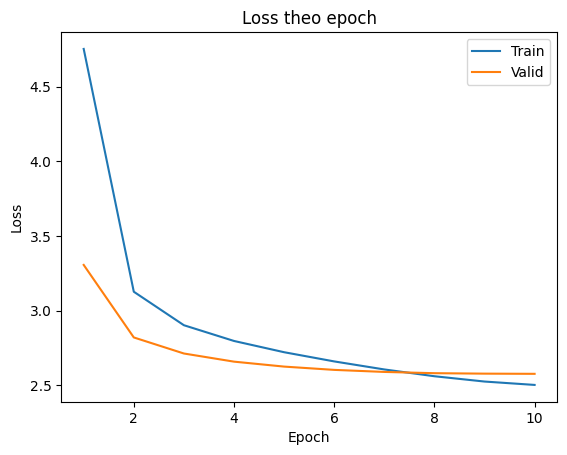

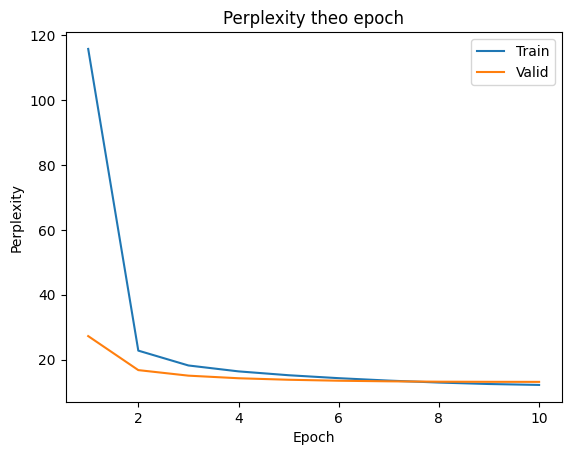

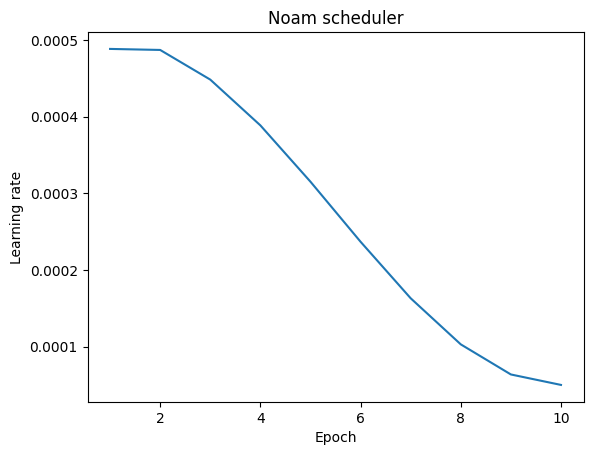

In [22]:
# ==== Cell 21: Vẽ Loss, Perplexity, Learning Rate ====

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure()
plt.plot(epochs, history["train_loss"], label="Train")
plt.plot(epochs, history["val_loss"],   label="Valid")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss theo epoch")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, history["train_ppl"], label="Train")
plt.plot(epochs, history["val_ppl"],   label="Valid")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Perplexity theo epoch")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, history["lr"])
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.title("Noam scheduler")
plt.show()

In [23]:
# ==== Cell 22: Hàm dịch (greedy, beam) & BLEU ====

def ids_to_tokens(ids, vocab: Vocab):
    toks = []
    for i in ids:
        if i == vocab.eos_idx:
            break
        if i in (vocab.sos_idx, vocab.pad_idx):
            continue
        toks.append(vocab.itos[i])
    return toks


@torch.no_grad()
def translate_greedy(sent_vi: str, model, src_vocab: Vocab, trg_vocab: Vocab,
                     max_len=64):
    model.eval()
    src_tokens = tokenize_vi(sent_vi)[: max_len - 2]
    src_ids = [src_vocab.sos_idx] + src_vocab.encode(src_tokens) + [src_vocab.eos_idx]
    src = torch.tensor(src_ids).unsqueeze(0).to(device)

    src_mask = make_src_mask(src, src_vocab.pad_idx)
    enc_out  = model.encoder(src, src_mask)

    trg_ids = [trg_vocab.sos_idx]
    for _ in range(max_len):
        trg = torch.tensor(trg_ids).unsqueeze(0).to(device)
        trg_mask = make_trg_mask(trg, trg_vocab.pad_idx)
        out = model.decoder(trg, enc_out, trg_mask, src_mask)
        next_tok = out[:, -1, :].argmax(dim=-1).item()
        trg_ids.append(next_tok)
        if next_tok == trg_vocab.eos_idx:
            break

    return " ".join(ids_to_tokens(trg_ids, trg_vocab))


@torch.no_grad()
def translate_beam(sent_vi: str, model, src_vocab: Vocab, trg_vocab: Vocab,
                   max_len=64, beam_size=5, length_penalty=1.0):
    model.eval()
    src_tokens = tokenize_vi(sent_vi)[: max_len - 2]
    src_ids = [src_vocab.sos_idx] + src_vocab.encode(src_tokens) + [src_vocab.eos_idx]
    src = torch.tensor(src_ids).unsqueeze(0).to(device)

    src_mask = make_src_mask(src, src_vocab.pad_idx)
    enc_out  = model.encoder(src, src_mask)

    beams = [(0.0, [trg_vocab.sos_idx])]
    completed = []

    for _ in range(max_len):
        new_beams = []
        for log_p, seq in beams:
            if seq[-1] == trg_vocab.eos_idx:
                completed.append((log_p, seq))
                continue

            trg = torch.tensor(seq).unsqueeze(0).to(device)
            trg_mask = make_trg_mask(trg, trg_vocab.pad_idx)
            out = model.decoder(trg, enc_out, trg_mask, src_mask)
            log_probs = out[:, -1, :].log_softmax(dim=-1).squeeze(0)

            topk_logp, topk_idx = torch.topk(log_probs, beam_size)
            for lp, idx in zip(topk_logp, topk_idx):
                new_seq = seq + [idx.item()]
                new_beams.append((log_p + lp.item(), new_seq))

        beams = sorted(new_beams, key=lambda x: x[0], reverse=True)[:beam_size]
        if len(completed) >= beam_size:
            break

    if not completed:
        completed = beams

    def score(item):
        log_p, seq = item
        L = len(seq)
        return log_p / (L ** length_penalty)

    best = max(completed, key=score)[1]
    return " ".join(ids_to_tokens(best, trg_vocab))


@torch.no_grad()
def bleu_on_test(model, src_sents, ref_sents,
                 src_vocab: Vocab, trg_vocab: Vocab,
                 max_len=64, beam_size=5):
    preds, refs = [], []
    for s_vi, s_en in tqdm(zip(src_sents, ref_sents),
                           total=len(src_sents),
                           desc="BLEU", leave=False):
        pred = translate_beam(s_vi, model, src_vocab, trg_vocab,
                              max_len=max_len, beam_size=beam_size)
        preds.append(pred)
        refs.append(s_en)
    bleu = sacrebleu.corpus_bleu(preds, [refs])
    return bleu, preds


In [ ]:
# ==== Cell 23: Load best model, dịch thử, tính BLEU (giới hạn N câu) ====

import torch

print("Đang load best model...")


state = torch.load(SAVE_PATH, map_location="cpu")

if any(k.startswith("module.") for k in state.keys()):
    state = {k.replace("module.", "", 1): v for k, v in state.items()}

best_model = Transformer(
    src_vocab_size=SRC_VOCAB,
    trg_vocab_size=TRG_VOCAB,
    src_pad_idx=SRC_PAD,
    trg_pad_idx=TRG_PAD,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    d_ff=D_FF,

    n_enc_layers=N_ENC_LAYERS,
    n_dec_layers=N_DEC_LAYERS,

    dropout=DROPOUT,
    droppath=DROPPATH,
    res_scale=RES_SCALE,
    rel_pos_max=REL_POS_MAX
)

# Load weight
best_model.load_state_dict(state, strict=True)


best_model = best_model.to(device).eval()

print("✔ Model load xong!")

# -------------------------------------------
# Dịch thử 5 câu
# -------------------------------------------
print("\nDịch thử 5 câu từ tập test:")
for i in range(5):
    print("=" * 50)
    print("SRC:", test_vi_raw[i])
    print("REF:", test_en_raw[i])
    print("GREEDY:", translate_greedy(test_vi_raw[i], best_model, vi_vocab, en_vocab))
    print("BEAM  :", translate_beam(test_vi_raw[i], best_model, vi_vocab, en_vocab, beam_size=5))

# -------------------------------------------
# Giới hạn số câu tính BLEU
# -------------------------------------------
TEST_LIMIT = 500   

if TEST_LIMIT is None:
    src_eval = test_vi_raw
    ref_eval = test_en_raw
    print(f"\nTính BLEU trên toàn bộ {len(test_vi_raw)} câu test.")
else:
    n_eval = min(TEST_LIMIT, len(test_vi_raw))
    src_eval = test_vi_raw[:n_eval]
    ref_eval = test_en_raw[:n_eval]
    print(f"\nTính BLEU trên {n_eval}/{len(test_vi_raw)} câu test...")

# -------------------------------------------
# Tính BLEU
# -------------------------------------------
bleu, preds_for_eval = bleu_on_test(
    best_model,
    src_eval,
    ref_eval,
    vi_vocab,
    en_vocab,
    max_len=MAX_LEN,
    beam_size=5
)

print("\n🎯 Test BLEU (beam search):", bleu.score)


Đang load best model...
✔ Model load xong!

Dịch thử 5 câu từ tập test:
SRC: Anh Albert Barnett và chị Susan Barnett, thuộc hội thánh West ở Tuscaloosa, Alabama
REF: Brother Albert Barnett and his wife, Sister Susan Barnett, from the West Congregation in Tuscaloosa, Alabama
GREEDY: albert <unk> and susan <unk> , of the west congregation in <unk> , alabama
BEAM  : albert <unk> and susan <unk> , of the west congregation in <unk> , alabama
SRC: Ngày 11 và 12-1-2020, những cơn bão lớn đã quét qua và phá huỷ nhiều vùng ở miền nam và miền trung Hoa Kỳ.
REF: Severe storms ripped through parts of the southern and midwestern United States on January 11 and 12, 2020.
GREEDY: on <unk> , 2020 , major storms swept through and destroyed many parts of the united states and south .
BEAM  : on january 11 and 12 , 2020 , major storms swept through and destroyed parts of the south and central united states .
SRC: Những trận mưa to và gió lớn trong suốt hai ngày cùng với nhiều cơn lốc xoáy đã gây thiệt hạ

BLEU:   0%|          | 0/500 [00:00<?, ?it/s]

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.



🎯 Test BLEU (beam search): 19.163012107640316


# 9. Xuất kết quả & Gemini Score

In [ ]:
import pandas as pd


n_eval = len(preds_for_eval)

df_eval = pd.DataFrame({
    "src_vi": src_eval[:n_eval],
    "ref_en": ref_eval[:n_eval],
    "pred_en": preds_for_eval
})

csv_path = "phomt_vi_en_predictions_for_gemini.csv"
df_eval.to_csv(csv_path, index=False, encoding="utf-8")

print("Đã lưu:", csv_path)
print(f"Số mẫu ghi vào CSV: {n_eval}")

Đã lưu: phomt_vi_en_predictions_for_gemini.csv
Số mẫu ghi vào CSV: 500


In [ ]:
# ==== Gemini Score (batch scoring, dùng Kaggle Secrets + flash-latest) ====
!pip install -q google-generativeai

import json, re
import numpy as np
from tqdm.auto import tqdm
import google.generativeai as genai
from kaggle_secrets import UserSecretsClient


user_secrets = UserSecretsClient()
API_KEY = user_secrets.get_secret("GEMINI-API-KEY") 

if not API_KEY:
    raise ValueError("❌ Không lấy được GEMINI_API_KEY từ Kaggle Secrets.")

genai.configure(api_key=API_KEY)

MODEL_ID = "gemini-flash-latest"
gemini_model = genai.GenerativeModel(MODEL_ID)
print("✔ Gemini model ready:", MODEL_ID)

src_list = src_eval if "src_eval" in globals() else test_vi_raw
ref_list = ref_eval if "ref_eval" in globals() else test_en_raw

n_available = min(len(src_list), len(ref_list), len(preds_for_eval))


MAX_GEMINI_SAMPLES = 100   
n = n_available if MAX_GEMINI_SAMPLES is None else min(MAX_GEMINI_SAMPLES, n_available)

BATCH_SIZE = 10          

print(f"Sẽ chấm {n}/{n_available} câu bằng Gemini, {BATCH_SIZE} câu / 1 request.")

all_scores = []

for start in tqdm(range(0, n, BATCH_SIZE), desc="Gemini batch scoring"):
    end = min(start + BATCH_SIZE, n)
    batch_indices = list(range(start, end))

    items_text = []
    for local_i, idx in enumerate(batch_indices, start=1):
        src = src_list[idx]
        ref = ref_list[idx]
        pred = preds_for_eval[idx]
        items_text.append(
            f"""Item {local_i}:
Source (Vietnamese):
{src}

Reference (English):
{ref}

Candidate (English):
{pred}
"""
        )

    batch_prompt = f"""
You are evaluating a batch of Vietnamese → English translations.

For each item below, compare the candidate translation with the reference
in terms of meaning preservation, fluency, and grammatical correctness.

For EACH item, give a score between 0 and 1 (0 = completely wrong, 1 = perfect).

Return the scores ONLY as a JSON array of numbers in order, e.g.:
[0.82, 0.45, 0.97]

Do not add any extra text.

{"".join(items_text)}
"""

    resp = gemini_model.generate_content(batch_prompt)
    text = resp.text.strip()

    try:
        batch_scores = json.loads(text)
    except Exception:
        nums = re.findall(r"(\d+(\.\d+)?)", text)
        batch_scores = [float(x[0]) for x in nums]
    if len(batch_scores) < len(batch_indices):
        batch_scores += [0.0] * (len(batch_indices) - len(batch_scores))
    batch_scores = batch_scores[:len(batch_indices)]

    batch_scores = [max(0.0, min(1.0, float(s))) for s in batch_scores]

    all_scores.extend(batch_scores)

all_scores = np.array(all_scores, dtype=float)
gemini_avg = float(all_scores.mean())

print("\n===== GEMINI SCORE (batch) =====")
print(f"Số câu đã chấm: {len(all_scores)}")
print("Gemini Score (0–1):   ", gemini_avg)
print("Gemini Score (0–100): ", gemini_avg * 100)


✔ Gemini model ready: gemini-flash-latest
Sẽ chấm 100/500 câu bằng Gemini, 10 câu / 1 request.


Gemini batch scoring:   0%|          | 0/10 [00:00<?, ?it/s]


===== GEMINI SCORE (batch) =====
Số câu đã chấm: 100
Gemini Score (0–1):    0.6268
Gemini Score (0–100):  62.68


In [ ]:
# 